<h1>
🐝 Projet ML/IA - 'To bee or not to bee'

<h3>1. Imports & Configuration

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from skimage.io import imread, imsave
from skimage.measure import regionprops, label
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import rotate
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import distance_transform_edt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8')

<h3>2. Load data and setup paths

In [45]:
image_dir = 'train/'
mask_dir = 'train/masks/'
cropped_dir = 'cropped/'
cropped_masks_dir = 'cropped/masks/'
inscribed_circles_dir = 'circles/'
test_image_dir = 'test/'  # For images 251-347
test_mask_dir = 'test/masks/'
extracted_features_file = 'extracted_features.csv'

<h5> Load data and display basic stats

In [46]:
try:
    label_df = pd.read_excel('classif.xlsx')
    print("Classification file loaded successfully")
    print(f"Number of training samples: {len(label_df)}")
    print("\nBug type distribution:")
    print(label_df['bug type'].value_counts())
    print("\nSpecies distribution:")
    print(label_df['species'].value_counts())
except Exception as e:
    print(f"Error loading classification file: {e}")

Classification file loaded successfully
Number of training samples: 250

Bug type distribution:
bug type
Bee                115
Bumblebee          100
Butterfly           15
Hover fly            9
Wasp                 9
Dragonfly            1
Bee & Bumblebee      1
Name: count, dtype: int64

Species distribution:
species
Bombus hortorum                              71
Apis mellifera                               58
Bombus pascuorum                             25
Anthidium manicatum                          19
Megachile centuncularis                      17
Eristalis                                     9
Vespula germanica                             8
Anthidium                                     6
Macroglossum stellatarum                      5
Andrenidae                                    4
Pieris rapae                                  4
Aglais urticae                                3
Thyreus                                       3
Polyommatus icarus                            2
Bombu

<h3>3. Mask Pre-Processing and Feature Extraction Functions

In [47]:
def preprocess_mask(mask_path, image_path=None, save_id=None):
    """
    Clean mask and crop iamge and mask to the bounding box
    """
    mask = imread(mask_path, as_gray=True) > 0
    labeled = label(mask)
    props = regionprops(labeled)

    if not props:
        return None, None

    largest = max(props, key=lambda x: x.area)
    clean_mask = labeled == largest.label
    minr, minc, maxr, maxc = largest.bbox
    cropped_mask = clean_mask[minr:maxr, minc:maxc]

    if image_path:
        image = imread(image_path)
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        cropped_image = image[minr:maxr, minc:maxc]
    else:
        cropped_image = None
        
    if save_id is not None:
        imsave(f'{cropped_masks_dir}cropped_mask_{save_id}.png', img_as_ubyte(cropped_mask.astype(bool)))
        if cropped_image is not None:
            imsave(f'{cropped_dir}cropped_image_{save_id}.png', img_as_ubyte(cropped_image))

    return cropped_mask, cropped_image

def find_best_inscribed_circle(binary_mask):
    """
    Return x, y and radius of the largest inscribed cricle in the mask.
    """
    distance = distance_transform_edt(binary_mask)
    centroid = np.array(regionprops(label(binary_mask))[0].centroid)

    def neg_radius(params):
        x, y = params
        if 0 <= int(y) < distance.shape[0] and 0 <= int(x) < distance.shape[1]:
            return -distance[int(y), int(x)]
        return 1e6

    result = minimize(neg_radius, x0=centroid[::-1],
                      bounds=[(0, binary_mask.shape[1]), (0, binary_mask.shape[0])])
    best_x, best_y = result.x
    best_radius = distance[int(best_y), int(best_x)]
    return best_x, best_y, best_radius

def save_inscribed_circle_overlay(image, center_x, center_y, radius, save_path):
    """
    Draw and save inscribed cricle
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image)
    circle = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def vertical_symmetry_loss(angle, image, xc, yc, mask=None):
    rotated = rotate(image, angle, resize=False, center=(xc, yc), preserve_range=True)
    flipped = rotated[:, ::-1, ...]
    difference = (rotated - flipped) ** 2
    if mask is not None:
        mask_rot = rotate(mask.astype(float), angle, resize=False, center=(xc, yc), preserve_range=True)
        return np.mean(difference[mask_rot > 0.5])
    return np.mean(difference)

def find_best_symmetry_angle(image, center_x, center_y, mask=None):
    result = minimize(vertical_symmetry_loss, x0=0, args=(image, center_x, center_y, mask), bounds=[(-45, 45)])
    return result.x[0]

def extract_comprehensive_features(image_path, mask_path, img_id=None):
    """
    Extract images / mask features.
    Project requirements and personnal additions
    """
    try:
        # Load cropped image and mask
        mask, image = preprocess_mask(mask_path, image_path, img_id)
        if mask is None or image is None:
            return None
        
        # Ensure image is 3D (RGB)
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=2)
        
        # Get region properties
        labeled_mask = label(mask.astype(int))
        props = regionprops(labeled_mask)
        
        features = {}
        
        # REQUIRED: Inscribed circle
        try:
            cx, cy, radius = find_best_inscribed_circle(mask)
            features['inscribed_circle_radius'] = radius
            circle_path = f'{inscribed_circles_dir}circle_{img_id}.png'
            save_inscribed_circle_overlay(image, cx, cy, radius, circle_path)
        except:
            features['inscribed_circle_radius'] = 0

        # REQUIRED: Vertical symetry
        try:
            symmetry_angle = find_best_symmetry_angle(image, cx, cy, mask)
            features['symmetry_angle'] = symmetry_angle
        except:
            features['symmetry_angle'] = 0
        
        # REQUIRED: Area ratio (pixels of bug / pixels of full image)
        total_pixels = mask.shape[0] * mask.shape[1]
        bug_pixels = np.sum(mask)
        features['area_ratio'] = bug_pixels / total_pixels
        
        # REQUIRED: RGB statistics within bug mask
        for i, color in enumerate(['R', 'G', 'B']):
            if image.shape[2] > i:
                channel = image[:, :, i]
                values = channel[mask]
                if len(values) > 0:
                    features[f'{color}_min'] = np.min(values)
                    features[f'{color}_max'] = np.max(values)
                    features[f'{color}_mean'] = np.mean(values)
                    features[f'{color}_median'] = np.median(values)
                    features[f'{color}_std'] = np.std(values)
                else:
                    # Handle empty mask case
                    for stat in ['min', 'max', 'mean', 'median', 'std']:
                        features[f'{color}_{stat}'] = 0
        
        # 3. REQUIRED: Shape and symmetry measures
        if props:
            prop = props[0]  # Take the largest connected component
            
            # Basic shape features
            # features['area'] = prop.area
            features['perimeter'] = prop.perimeter
            features['eccentricity'] = prop.eccentricity
            # features['solidity'] = prop.solidity
            features['extent'] = prop.extent
            features['convex_area'] = prop.convex_area
            
            # Symmetry measures
            features['major_axis_length'] = prop.major_axis_length
            features['minor_axis_length'] = prop.minor_axis_length
            features['aspect_ratio'] = prop.major_axis_length / max(prop.minor_axis_length, 1e-6)
            
            # Compactness and roundness
            features['compactness'] = (prop.perimeter ** 2) / max(prop.area, 1e-6)
            features['roundness'] = (4 * np.pi * prop.area) / max(prop.perimeter ** 2, 1e-6)
            
            # Orientation
            features['orientation'] = prop.orientation
            
        else:
            # Default values if no region found
            shape_features = ['area', 'perimeter', 'eccentricity', 'solidity', 'extent', 
                            'convex_area', 'major_axis_length', 'minor_axis_length', 
                            'aspect_ratio', 'compactness', 'roundness', 'orientation']
            for feat in shape_features:
                features[feat] = 0
        
      
        """
        # Texture features using Gray-Level Co-occurrence Matrix (GLCM)
        if len(image.shape) == 3:
            gray_image = np.mean(image, axis=2).astype(np.uint8)
        else:
            gray_image = image.astype(np.uint8)
        
        # Apply mask to gray image
        masked_gray = gray_image.copy()
        masked_gray[~mask] = 0
        
        # Calculate GLCM properties
        try:
            # Reduce levels for GLCM computation
            gray_levels = 32
            gray_reduced = (masked_gray[mask] / 255 * (gray_levels - 1)).astype(np.uint8)
            
            if len(gray_reduced) > 10:  # Ensure we have enough pixels
                # Create a small region for GLCM
                bbox = props[0].bbox if props else (0, 0, min(50, mask.shape[0]), min(50, mask.shape[1]))
                y1, x1, y2, x2 = bbox
                region = gray_image[y1:y2, x1:x2]
                region_mask = mask[y1:y2, x1:x2]
                
                if np.sum(region_mask) > 0:
                    region_masked = region.copy()
                    region_masked[~region_mask] = 0
                    region_reduced = (region_masked / 255 * (gray_levels - 1)).astype(np.uint8)
                    
                    # Compute GLCM
                    glcm = graycomatrix(region_reduced, [1], [0], levels=gray_levels, symmetric=True, normed=True)
                    
                    # Extract texture properties
                    features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
                    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
                    features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
                    features['energy'] = graycoprops(glcm, 'energy')[0, 0]
                else:
                    features['contrast'] = 0
                    features['dissimilarity'] = 0
                    features['homogeneity'] = 0
                    features['energy'] = 0
            else:
                features['contrast'] = 0
                features['dissimilarity'] = 0
                features['homogeneity'] = 0
                features['energy'] = 0
        except:
            features['contrast'] = 0
            features['dissimilarity'] = 0
            features['homogeneity'] = 0
            features['energy'] = 0
        
        # Edge density feature
        try:
            # Calculate edge density within the mask
            edges = sobel(gray_image)
            edge_density = np.sum(edges[mask]) / max(np.sum(mask), 1)
            features['edge_density'] = edge_density
        except:
            features['edge_density'] = 0
        """

        return features
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

<h3>4. Extract features from training set</h3>

In [48]:
print("Extracting features from training images...")
feature_list = []
failed_extractions = []
if os.path.exists(extracted_features_file):
    print(f"Loading existing features from {extracted_features_file}")
    feature_list = pd.read_csv(extracted_features_file).to_dict(orient='records')

else:
    print("No existing features found, extracting from scratch.")
    for i, row in label_df.iterrows():
        img_id = row['ID']
        img_path = os.path.join(image_dir, f"{img_id}.JPG")
        mask_path = os.path.join(mask_dir, f"binary_{img_id}.tif")
        
        # We make sure to check if image and mask exist for each ID
        try:
            if not os.path.exists(img_path):
                print(f"[WARNING] Image missing: {img_path}")
                failed_extractions.append(img_id)
                continue
            if not os.path.exists(mask_path):
                print(f"[WARNING] Mask missing: {mask_path}")
                failed_extractions.append(img_id)
                continue
            
            features = extract_comprehensive_features(img_path, mask_path, img_id)
            if features is not None:
                features['ID'] = img_id
                features['bug_type'] = row['bug type']
                features['species'] = row['species']
                feature_list.append(features)
            else:
                failed_extractions.append(img_id)
                
        except Exception as e:
            print(f"[ERROR] Problem with ID {img_id}: {e}")
            failed_extractions.append(img_id)

Extracting features from training images...
No existing features found, extracting from scratch.
[WARNING] Mask missing: train/masks/binary_154.tif


<h3> Storing extracted features into a pandas dataframe and extracting into csv format

In [49]:
df_features = pd.DataFrame(feature_list)
print(f"\nFeature extraction completed!")
print(f"Successfully processed: {len(df_features)} images")
print(f"Failed extractions: {len(failed_extractions)} images")
print(f"Feature dimensions: {df_features.shape}")

# Display basic statistics
print("\n=== FEATURE SUMMARY ===")
feature_cols = [col for col in df_features.columns if col not in ['ID', 'bug_type', 'species']]
print(f"Total features extracted: {len(feature_cols)}")
print("\nFeature list:")
for i, feat in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feat}")

# Save features to CSV 
df_features.to_csv('extracted_features.csv', index=False)
print("\nFeatures saved to 'extracted_features.csv'")

print("\n=== SAMPLE DATA ===")
print(df_features.head())


Feature extraction completed!
Successfully processed: 249 images
Failed extractions: 1 images
Feature dimensions: (249, 31)

=== FEATURE SUMMARY ===
Total features extracted: 28

Feature list:
 1. inscribed_circle_radius
 2. symmetry_angle
 3. area_ratio
 4. R_min
 5. R_max
 6. R_mean
 7. R_median
 8. R_std
 9. G_min
10. G_max
11. G_mean
12. G_median
13. G_std
14. B_min
15. B_max
16. B_mean
17. B_median
18. B_std
19. perimeter
20. eccentricity
21. extent
22. convex_area
23. major_axis_length
24. minor_axis_length
25. aspect_ratio
26. compactness
27. roundness
28. orientation

Features saved to 'extracted_features.csv'

=== SAMPLE DATA ===
   inscribed_circle_radius  symmetry_angle  area_ratio  R_min  R_max  \
0               128.128841               0    0.506544      5    208   
1               109.658561               0    0.431831      2    248   
2               179.175891               0    0.448143      3    255   
3               104.345580               0    0.427390      5   

<h3> 5. Data Visualisation </h3>
<h5> 5.1 Bug type and species distribution

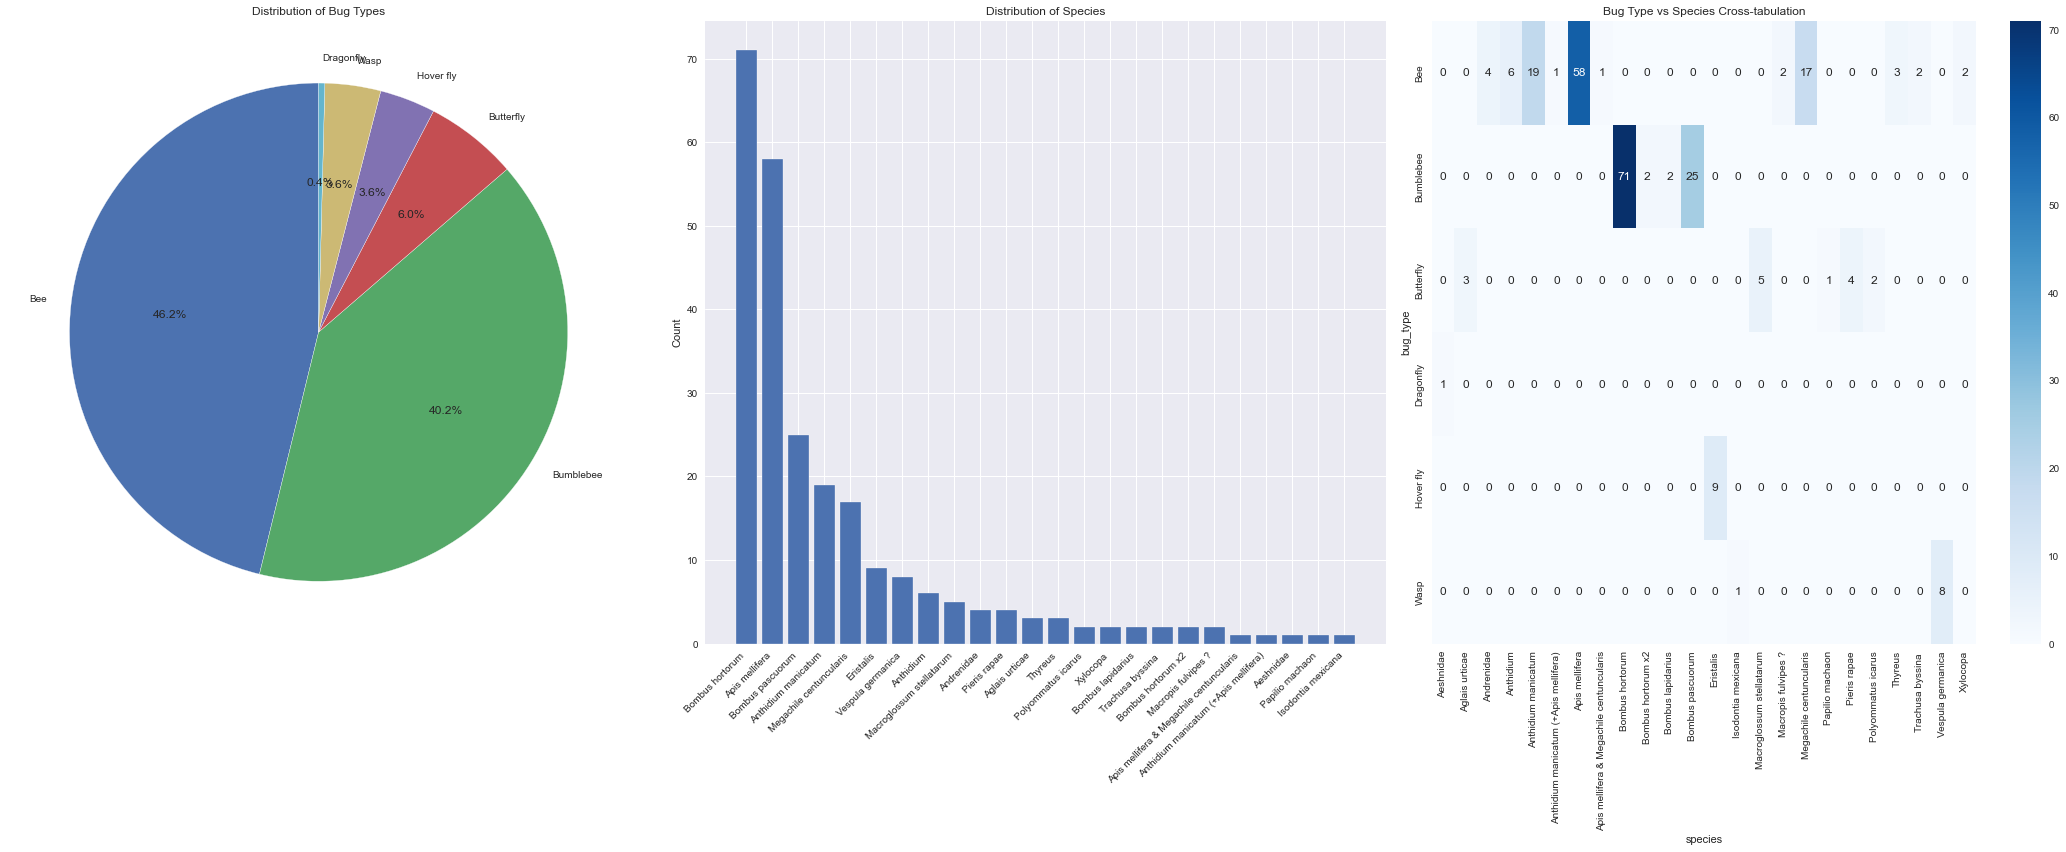

In [50]:
plt.figure(figsize=(30, 12))

plt.subplot(1, 3, 1)
bug_counts = df_features['bug_type'].value_counts()
plt.pie(bug_counts.values, labels=bug_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Bug Types')

plt.subplot(1, 3, 2)
species_counts = df_features['species'].value_counts()
plt.bar(range(len(species_counts)), species_counts.values)
plt.xticks(range(len(species_counts)), species_counts.index, rotation=45, ha='right')
plt.title('Distribution of Species')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
# Cross-tabulation
ct = pd.crosstab(df_features['bug_type'], df_features['species'])
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title('Bug Type vs Species Cross-tabulation')

plt.tight_layout()
plt.show()

<h5>5.2 PCA Projection 


=== PCA ANALYSIS ===
PCA Variance explained by first 2 components: [0.27566285 0.15320956]
Total variance explained: 0.429


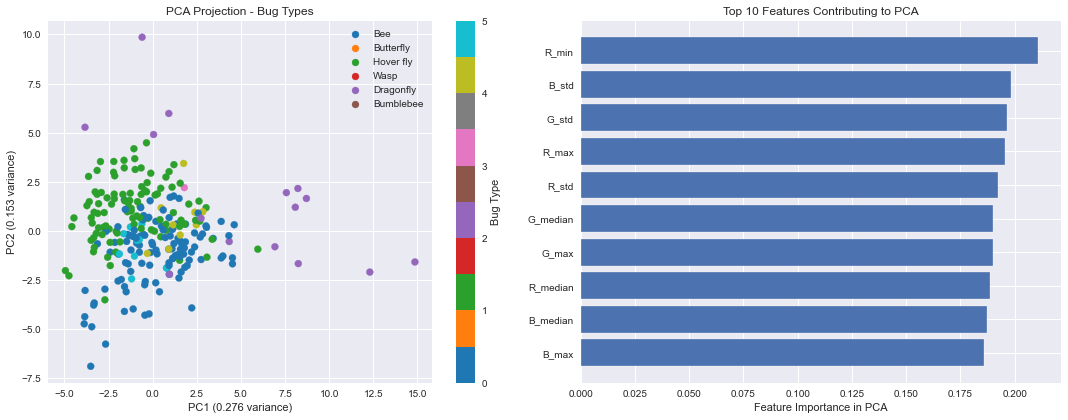

In [51]:
print("\n=== PCA ANALYSIS ===")

# Prepare data for PCA
X = df_features[feature_cols].fillna(0)
y_bug_type = df_features['bug_type']
y_species = df_features['species']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA Variance explained by first 2 components: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

# Plot PCA results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Categorical(y_bug_type).codes, cmap='tab10')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
plt.title('PCA Projection - Bug Types')
plt.colorbar(scatter, label='Bug Type')

# Add legend
unique_types = y_bug_type.unique()
for i, bug_type in enumerate(unique_types):
    plt.scatter([], [], c=plt.cm.tab10(i), label=bug_type)
plt.legend()

plt.subplot(1, 2, 2)
# Feature importance in PCA
feature_importance = np.abs(pca.components_).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-10:]
top_features = [feature_cols[i] for i in top_features_idx]
top_importance = feature_importance[top_features_idx]

plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance in PCA')
plt.title('Top 10 Features Contributing to PCA')

plt.tight_layout()
plt.show()

<h5>5.3 Non-linear projections 


=== NON-LINEAR PROJECTIONS ===
Computing t-SNE projection...
UMAP not available, using Isomap instead...


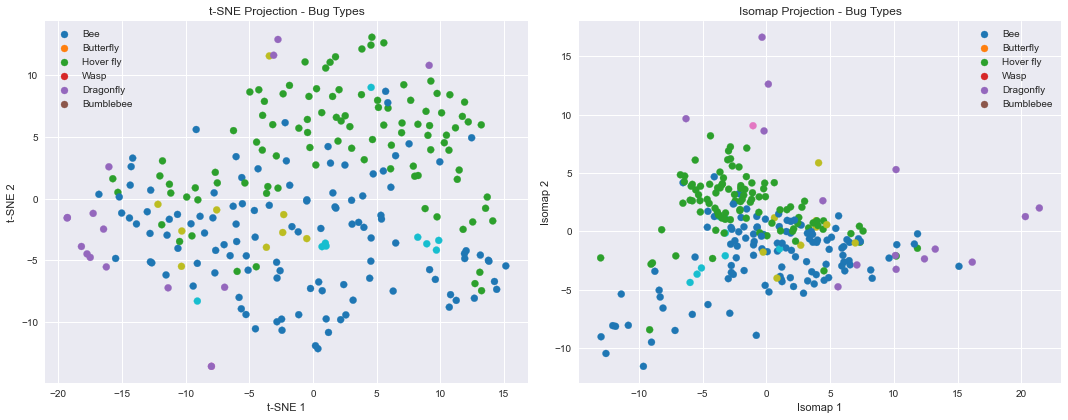

In [52]:
print("\n=== NON-LINEAR PROJECTIONS ===")

# t-SNE projection
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)-1))
X_tsne = tsne.fit_transform(X_scaled)

# UMAP projection (if available, otherwise use another method)
try:
    from umap import UMAP
    print("Computing UMAP projection...")
    umap_reducer = UMAP(n_components=2, random_state=42)
    X_umap = umap_reducer.fit_transform(X_scaled)
    has_umap = True
except ImportError:
    print("UMAP not available, using Isomap instead...")
    from sklearn.manifold import Isomap
    isomap = Isomap(n_components=2)
    X_umap = isomap.fit_transform(X_scaled)
    has_umap = False

# Plot non-linear projections
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=pd.Categorical(y_bug_type).codes, cmap='tab10')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Projection - Bug Types')
# Add legend
for i, bug_type in enumerate(unique_types):
    plt.scatter([], [], c=plt.cm.tab10(i), label=bug_type)
plt.legend()

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=pd.Categorical(y_bug_type).codes, cmap='tab10')
plt.xlabel('UMAP 1' if has_umap else 'Isomap 1')
plt.ylabel('UMAP 2' if has_umap else 'Isomap 2')
plt.title(f'{"UMAP" if has_umap else "Isomap"} Projection - Bug Types')
# Add legend
for i, bug_type in enumerate(unique_types):
    plt.scatter([], [], c=plt.cm.tab10(i), label=bug_type)
plt.legend()

plt.tight_layout()
plt.show()

<h3>6. Machine Learning Algorithms

<h5>Data preparation

In [53]:
# Prepare data
X_ml = df_features[feature_cols].fillna(0)
y_ml = df_features['bug_type']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42) # enlevé stratify parce que certaines classes < 2

# Standardize features
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)
X_test_scaled = scaler_ml.transform(X_test)

<h5>6.1 Supervised Methods</h5>
<h7>Method 1: Support Vector Machine

In [54]:
print("\n--- SVM Classifier ---")
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_scaled, y_train)
svm_pred = svm_clf.predict(X_test_scaled)

print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, svm_pred))


--- SVM Classifier ---
SVM Classification Report:
              precision    recall  f1-score   support

         Bee       0.77      0.67      0.71        30
   Bumblebee       0.52      0.73      0.61        15
   Butterfly       0.33      0.50      0.40         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.64        50
   macro avg       0.33      0.38      0.35        50
weighted avg       0.63      0.64      0.63        50

SVM Confusion Matrix:
[[20  9  1  0  0]
 [ 4 11  0  0  0]
 [ 1  0  1  0  0]
 [ 0  1  1  0  0]
 [ 1  0  0  0  0]]


<h7>Method 2: K-Nearest Neighbors

In [55]:
print("\n--- KNN Classifier ---")
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_scaled, y_train)
knn_pred = knn_clf.predict(X_test_scaled)

print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, knn_pred))


--- KNN Classifier ---
KNN Classification Report:
              precision    recall  f1-score   support

         Bee       0.81      0.70      0.75        30
   Bumblebee       0.55      0.80      0.65        15
   Butterfly       1.00      0.50      0.67         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       1.00      1.00      1.00         1

    accuracy                           0.70        50
   macro avg       0.67      0.60      0.61        50
weighted avg       0.71      0.70      0.69        50

KNN Confusion Matrix:
[[21  9  0  0  0]
 [ 3 12  0  0  0]
 [ 1  0  1  0  0]
 [ 1  1  0  0  0]
 [ 0  0  0  0  1]]


<h5>6.2 Ensemble Learning Method 

<h7> Random forest


--- Random Forest Classifier (Ensemble) ---
Random Forest Classification Report:
              precision    recall  f1-score   support

         Bee       0.78      0.70      0.74        30
   Bumblebee       0.55      0.73      0.63        15
   Butterfly       0.50      0.50      0.50         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       1.00      1.00      1.00         1

    accuracy                           0.68        50
   macro avg       0.57      0.59      0.57        50
weighted avg       0.67      0.68      0.67        50

Random Forest Confusion Matrix:
[[21  9  0  0  0]
 [ 4 11  0  0  0]
 [ 1  0  1  0  0]
 [ 1  0  1  0  0]
 [ 0  0  0  0  1]]


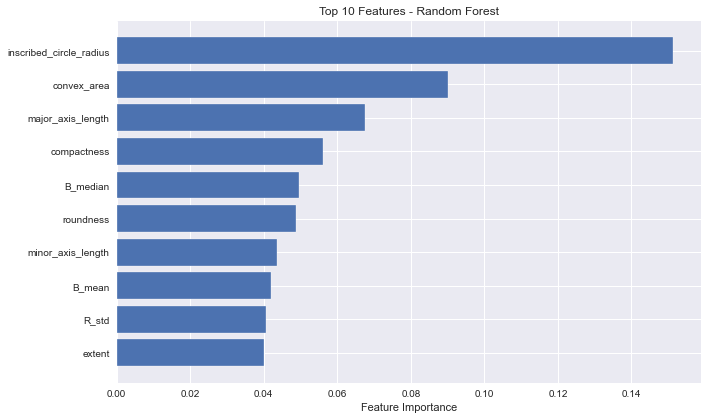

In [56]:
print("\n--- Random Forest Classifier (Ensemble) ---")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)  # RF can handle unscaled data
rf_pred = rf_clf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

# Feature importance from Random Forest
feature_importance_rf = rf_clf.feature_importances_
top_features_rf_idx = np.argsort(feature_importance_rf)[-10:]
top_features_rf = [feature_cols[i] for i in top_features_rf_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features_rf)), feature_importance_rf[top_features_rf_idx])
plt.yticks(range(len(top_features_rf)), top_features_rf)
plt.xlabel('Feature Importance')
plt.title('Top 10 Features - Random Forest')
plt.tight_layout()
plt.show()

<h7> Voting classifier

In [57]:
print("\n--- Voting Classifier (Ensemble) ---")
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True, random_state=42)),
        ('knn', KNeighborsClassifier())
    ],
    voting='soft'  # 'hard' for main classes, 'soft' for probabilities
)

voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, voting_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, voting_pred))


--- Voting Classifier (Ensemble) ---
Random Forest Classification Report:
              precision    recall  f1-score   support

         Bee       0.78      0.60      0.68        30
   Bumblebee       0.38      0.67      0.49        15
   Butterfly       0.00      0.00      0.00         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.56        50
   macro avg       0.23      0.25      0.23        50
weighted avg       0.58      0.56      0.55        50

Random Forest Confusion Matrix:
[[18 12  0  0  0]
 [ 5 10  0  0  0]
 [ 0  2  0  0  0]
 [ 0  1  1  0  0]
 [ 0  1  0  0  0]]


<h7> Stacking classifier

In [58]:
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
]

meta_model = GradientBoostingClassifier()

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5  
)

stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, stacking_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, stacking_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

         Bee       0.78      0.60      0.68        30
   Bumblebee       0.48      0.67      0.56        15
   Butterfly       0.50      0.50      0.50         2
   Dragonfly       0.00      0.00      0.00         0
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.33      1.00      0.50         1

    accuracy                           0.60        50
   macro avg       0.35      0.46      0.37        50
weighted avg       0.64      0.60      0.60        50

Random Forest Confusion Matrix:
[[18 11  1  0  0  0]
 [ 4 10  0  0  0  1]
 [ 0  0  1  0  0  1]
 [ 0  0  0  0  0  0]
 [ 1  0  0  1  0  0]
 [ 0  0  0  0  0  1]]


<h5>6.3 Clustering Methods

<h7>Method 1: K-Means Clustering

In [59]:
print("\n--- K-Means Clustering ---")
n_clusters = len(df_features['bug_type'].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")


--- K-Means Clustering ---
K-Means Silhouette Score: 0.122


<h7>Method 2: DBSCAN Clustering

In [60]:
print("\n--- DBSCAN Clustering ---")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN - Estimated clusters: {n_clusters_dbscan}")
print(f"DBSCAN - Noise points: {n_noise}")

if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")


--- DBSCAN Clustering ---
DBSCAN - Estimated clusters: 0
DBSCAN - Noise points: 249


<h7>Method 3: Hierarchical Clustering

In [61]:
print("\n--- Hierarchical Clustering ---")
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette:.3f}")


--- Hierarchical Clustering ---
Hierarchical Silhouette Score: 0.123


<h7>Plot clustering results

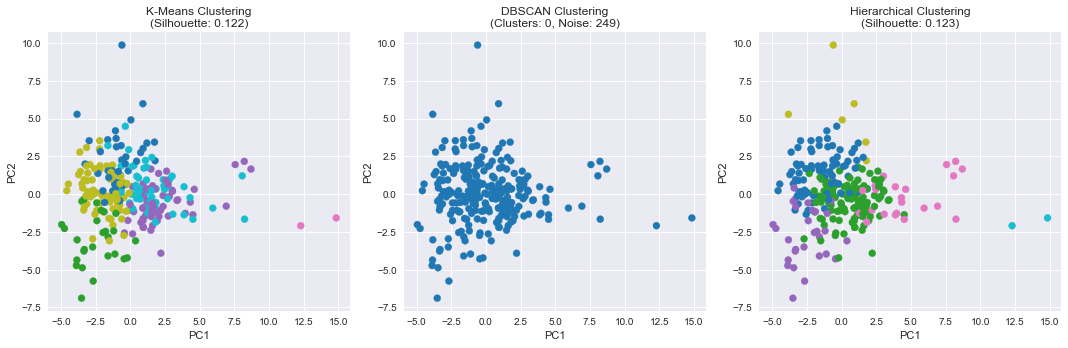

In [62]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10')
plt.title(f'K-Means Clustering\n(Silhouette: {kmeans_silhouette:.3f})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10')
plt.title(f'DBSCAN Clustering\n(Clusters: {n_clusters_dbscan}, Noise: {n_noise})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='tab10')
plt.title(f'Hierarchical Clustering\n(Silhouette: {hierarchical_silhouette:.3f})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

<h5>6.4 Hyperparameter Optimization 

<h7> Grid Search for SVM

In [63]:
print("\n--- SVM with Grid Search ---")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train_scaled, y_train)

print(f"Best SVM parameters: {svm_grid_search.best_params_}")
print(f"Best SVM score: {svm_grid_search.best_score_:.3f}")

# Test best SVM
best_svm = svm_grid_search.best_estimator_
best_svm_pred = best_svm.predict(X_test_scaled)
print("Optimized SVM Classification Report:")
print(classification_report(y_test, best_svm_pred))


--- SVM with Grid Search ---
Best SVM parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM score: 0.845
Optimized SVM Classification Report:
              precision    recall  f1-score   support

         Bee       0.88      0.77      0.82        30
   Bumblebee       0.65      0.87      0.74        15
   Butterfly       0.50      0.50      0.50         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       1.00      1.00      1.00         1

    accuracy                           0.76        50
   macro avg       0.61      0.63      0.61        50
weighted avg       0.77      0.76      0.76        50



<h7>Randomized Search for Random Forest  

In [64]:
print("\n--- Random Forest with Randomized Search ---")
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_dist, 
                                      n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
rf_random_search.fit(X_train, y_train)

print(f"Best RF parameters: {rf_random_search.best_params_}")
print(f"Best RF score: {rf_random_search.best_score_:.3f}")

# Test best Random Forest
best_rf = rf_random_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)
print("Optimized RF Classification Report:")
print(classification_report(y_test, best_rf_pred))


--- Random Forest with Randomized Search ---
Best RF parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}
Best RF score: 0.799
Optimized RF Classification Report:
              precision    recall  f1-score   support

         Bee       0.79      0.73      0.76        30
   Bumblebee       0.58      0.73      0.65        15
   Butterfly       0.50      0.50      0.50         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       1.00      1.00      1.00         1

    accuracy                           0.70        50
   macro avg       0.57      0.59      0.58        50
weighted avg       0.69      0.70      0.69        50



<h3>7. Models comparison

In [65]:
print("\n=== MODEL COMPARISON ===")

models = {
    'SVM': (svm_clf, svm_pred),
    'KNN': (knn_clf, knn_pred),
    'Random Forest': (rf_clf, rf_pred),
    'Voting Classifier': (voting_clf, voting_pred),
    'Stacking Classifier': (stacking_clf, stacking_pred),
    'SVM (Optimized)': (best_svm, best_svm_pred),
    'RF (Optimized)': (best_rf, best_rf_pred)
}

print("Model Accuracy Comparison:")
print("-" * 40)
for name, (model, pred) in models.items():
    accuracy = accuracy_score(y_test, pred)
    print(f"{name:20s}: {accuracy:.3f}")


=== MODEL COMPARISON ===
Model Accuracy Comparison:
----------------------------------------
SVM                 : 0.640
KNN                 : 0.700
Random Forest       : 0.680
Voting Classifier   : 0.560
Stacking Classifier : 0.600
SVM (Optimized)     : 0.760
RF (Optimized)      : 0.700


<h3>8. Prepare for test data processing

In [66]:
print("\n=== PREPARING FOR TEST DATA ===")

# Select best model based on performance
best_model_name = max(models.keys(), key=lambda k: accuracy_score(y_test, models[k][1]))
best_model = models[best_model_name][0]

print(f"Selected best model: {best_model_name}")
print(f"Best model accuracy: {accuracy_score(y_test, models[best_model_name][1]):.3f}")


=== PREPARING FOR TEST DATA ===
Selected best model: SVM (Optimized)
Best model accuracy: 0.760


<h5>8.1 Function to process test images (251 - 347)

In [ ]:
def process_test_images():
    """Process test images and generate predictions"""
    test_results = []
    
    # Assuming test images are numbered 251-347
    for img_id in range(251, 348):
        img_path = os.path.join(test_image_dir, f"{img_id}.JPG")
        mask_path = os.path.join(test_mask_dir, f"binary_{img_id}.tif")
        
        if os.path.exists(img_path) and os.path.exists(mask_path):
            # Extract features
            features = extract_comprehensive_features(img_path, mask_path)
            if features is not None:
                # Remove non-feature columns
                feature_vector = [features.get(col, 0) for col in feature_cols]
                
                # Scale features using the same scaler
                if best_model_name in ['SVM', 'SVM (Optimized)', 'KNN']:
                    feature_vector_scaled = scaler_ml.transform([feature_vector])
                    prediction = best_model.predict(feature_vector_scaled)[0]
                else:
                    prediction = best_model.predict([feature_vector])[0]
                
                test_results.append({'ID': img_id, 'bug type': prediction})
    
    return test_results

<h5>8.2 Save preprocessing objects for use with test data

In [ ]:
import pickle

preprocessing_objects = {
    'scaler': scaler_ml,
    'feature_columns': feature_cols,
    'best_model': best_model,
    'best_model_name': best_model_name
}

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print("Preprocessing objects saved for test data processing")

<h3> Summary

In [ ]:
print("\n=== PROJECT SUMMARY ===")
print(f"✓ Feature extraction completed: {len(feature_cols)} features")
print(f"✓ Data visualization: Distributions, PCA, t-SNE, {'UMAP' if has_umap else 'Isomap'}")
print(f"✓ Supervised methods: SVM, KNN")
print(f"✓ Ensemble method: Random Forest")
print(f"✓ Clustering methods: K-Means, DBSCAN, Hierarchical")
print(f"✓ Hyperparameter optimization: Grid Search (SVM), Randomized Search (RF)")
print(f"✓ Best model selected: {best_model_name}")